## Fortran cython i numpy

Porównanie różnych podejść - do rozwiązywanie równania dyfuzji jawnym algorytmem.

Obliczanie operatora Laplace'a na siatce z f2py, stosując wektorowy kod w f90 działa najszybciej!



In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [5]:
%load_ext Cython

In [6]:
%%cython
cimport cython
cimport numpy as np

@cython.wraparound(False)
@cython.boundscheck(False)
def cython_diff2d(np.ndarray[double, ndim=2] u,np.ndarray[double, ndim=2] v, double dx2, double dy2, double c):
    cdef unsigned int i, j
    for i in xrange(1,u.shape[0]-1):
        for j in xrange(1, u.shape[1]-1):
            v[i,j] = u[i,j] + c*( (u[i+1, j] + u[i-1, j]-2.0*u[i,j])/dy2 +
                                  (u[i, j+1] + u[i, j-1]-2.0*u[i,j])/dx2 )

            
            

In [7]:
def numpy_diff2d(u,v,dx2,dy2,c):
    v[1:-1,1:-1] =u[1:-1,1:-1] + c*((u[2:,1:-1]+u[:-2,1:-1]-2.0*u[1:-1,1:-1])/dy2 + 
                    (u[1:-1,2:] + u[1:-1,:-2]-2.0*u[1:-1,1:-1])/dx2)
    

In [8]:
def numpy_diff2d_a(u,v,dx2,dy2,c):
    A = (1.0-2.0*(c/dx2+c/dy2))
    v[1:-1,1:-1] =A*u[1:-1,1:-1] + c/dy2*(u[2:,1:-1] + u[:-2,1:-1]) + \
                                   c/dx2*(u[1:-1,2:] + u[1:-1,:-2])
    

In [9]:
def numpy_diff2d_b(u,v,dx2,dy2,c):
    
    v[1:-1,1:-1] =u[1:-1,1:-1] + c/dx2*(np.diff(u,2,axis=0)[:,1:-1] + np.diff(u,2,axis=1)[1:-1,:])
    

In [14]:
def calc(N, Niter, func, dx2,dy2,c):
    u = np.zeros([N, N])
    v = np.zeros_like(u)
    u[u.shape[0]/2,u.shape[1]/2] = 1.0/np.sqrt(dx2*dy2)
    for i in range(Niter/2):
        func(u,v,dx2,dy2,c)
        func(v,u,dx2,dy2,c)
    return u

## Parametry symulacji

In [15]:
N=100
dx = 0.1
dy = 0.1
dx2 = dx*dx
dy2 = dy*dy
dt = 0.01
D = 0.1
c = D*dt
print "CLF = ",c/dx2,c/dy2

CLF =  0.1 0.1


## Walidacja wyników

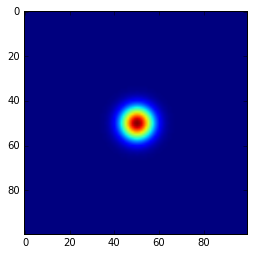

In [17]:
u = calc(N,125,numpy_diff2d_b,dx2,dy2,c)
plt.imshow(u)

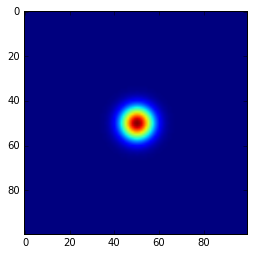

In [18]:
u = calc(N,125,cython_diff2d,dx2,dy2,c)
plt.imshow(u)

znamy rozwiązanie równania dyfuzji na nieskończonym obszarze startujące z punktu 
$$ u(x,0) = \delta (x)$$

$$ u(x,t) =  \frac{1}{4 \, \pi D t}e^{\left(-\frac{x^{2} + y^{2}}{4  D t}\right)}$$

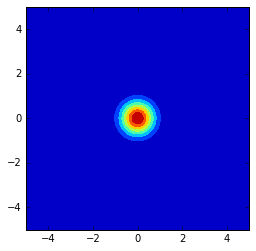

In [19]:
Lx,Ly = N/2*dx,N/2*dy
x  = np.linspace(-Lx,Lx,N)
y  = np.linspace(-Ly,Ly,N)

X,Y = np.meshgrid(x,y )
Niter = 125
t = dt*Niter
P = 1/(4*np.pi*D*t)*np.exp(-(X**2+Y**2)/(4*D*t) )
plt.contourf(X,Y,P)
plt.axes().set_aspect('equal')

In [20]:
u = calc(N,Niter,cython_diff2d,dx2,dy2,c)
np.sum(P)*dx2,np.sum(u)*dx2

(0.98010000000000008, 1.0000000000000002)

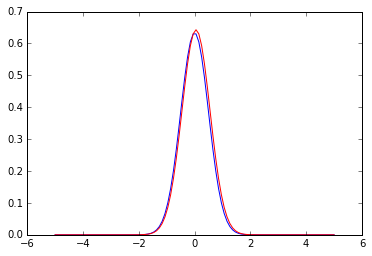

In [21]:
plt.plot(X[X.shape[0]/2,:],P[X.shape[0]/2,:],'b')
plt.plot(X[X.shape[0]/2,:],u[X.shape[0]/2,:],'r')

## Benchmarks

In [22]:
%%time
u = calc(1000,200,cython_diff2d,dx2,dy2,c)

CPU times: user 1.11 s, sys: 4 ms, total: 1.12 s
Wall time: 1.11 s


In [23]:
%%time
u = calc(1000,200,numpy_diff2d,dx2,dy2,c)

CPU times: user 3.13 s, sys: 1.79 s, total: 4.92 s
Wall time: 4.91 s


In [24]:
%%time
u = calc(1000,200,numpy_diff2d_a,dx2,dy2,c)

CPU times: user 2.02 s, sys: 492 ms, total: 2.52 s
Wall time: 2.51 s


In [25]:
%%time
u = calc(1000,200,numpy_diff2d_b,dx2,dy2,c)

CPU times: user 1.89 s, sys: 816 ms, total: 2.71 s
Wall time: 2.7 s


In [26]:
N = 1000
fortran_source = """

subroutine fortran_diff2d(u, v, dx2, dy2, c)
real(8), intent(inout) :: u({0}, {1})
real(8), intent(inout) :: v({0}, {1})
real(8), intent(in) :: dx2, dy2, c
v(2:{0}-1,2:{1}-1) = u(2:{0}-1,2:{1}-1)+ c*( (u(3:,2:{1}-1)+u(:{0}-2,2:{1}-1))/dy2 + &
        (u(2:{0}-1,3:) + u(2:{0}-1,:{1}-2))/dx2)
end subroutine 

""".format(N,N)

fp = open("myfile.f90", "w")
fp.write(fortran_source)
fp.close()


In [27]:
!cat myfile.f90




subroutine fortran_diff2d(u, v, dx2, dy2, c)
real(8), intent(inout) :: u(1000, 1000)
real(8), intent(inout) :: v(1000, 1000)
real(8), intent(in) :: dx2, dy2, c
v(2:1000-1,2:1000-1) = u(2:1000-1,2:1000-1)+ c*( (u(3:,2:1000-1)+u(:1000-2,2:1000-1))/dy2 + &
        (u(2:1000-1,3:) + u(2:1000-1,:1000-2))/dx2)
end subroutine 



In [28]:
%%capture f2pylog
!f2py -c -m my_fortran_module myfile.f90

In [29]:
from my_fortran_module import fortran_diff2d

In [30]:
def calcF(N, Niter, func, dx2,dy2,c):
    u = np.zeros([N, N],order='F')
    v = np.zeros_like(u)
    u[u.shape[0]/2,u.shape[1]/2] = 1.0/np.sqrt(dx2*dy2)
    for i in range(Niter/2):
        func(u,v,dx2,dy2,c)
        func(v,u,dx2,dy2,c)
    return u

In [31]:
%%time
u = calcF(1000,200,fortran_diff2d,dx2,dy2,c)

CPU times: user 584 ms, sys: 0 ns, total: 584 ms
Wall time: 580 ms


### Najszybsza wersja - wektorowy Fortran

Warto zauważyć, że:

 - nie zawsze jest taka duża różnica miedzy numpy/Cython/Fortran, *sprawdź dla np. mapowania funkcji na tablicy wartości*
 - numpy jest kilka razy wolniejsze bo przy każdym działaniu stosuje wartości pośrednie
 - istnieje możliwośc obejścia z pomocą modułu numexpr, który kompiluje całe wyrażenie na tablicy numpy, *sprawdź!*
 - wektorowy Fortran najefektywniej kompiluje wyrażenia typu $u_i+u_{i+1}$
 
Wniosek - warto stosować Fortran do pewnych operacji!

## Automatyczna generacja kodu

*Problem: kompilowane moduły nie mogą być ponownie ładowane.*

Przeanalizujmy prostą metodę generacji kodu 


In [33]:
import subprocess
subprocess.check_output(["pwd"])

'/home/users/marcin.kostur/ProgramowanieRownolegle/MPI\n'

In [34]:
import subprocess
import importlib

counter = 12

In [35]:
def prepare_fortran_module(N=100):
    
    global counter
    fortran_source = """

subroutine fortran_diff2d(u, v, dx2, dy2, c)
real(8), intent(in) :: u({0}, {1})
real(8), intent(inout) :: v({0}, {1})
real(8), intent(in) :: dx2, dy2, c
v(2:{0}-1,2:{1}-1) = u(2:{0}-1,2:{1}-1)+ c*( (u(3:,2:{1}-1)+u(:{0}-2,2:{1}-1))/dy2 + &
        (u(2:{0}-1,3:) + u(2:{0}-1,:{1}-2))/dx2)
end subroutine 

subroutine fortran_diff2d_a(u, dx2, dy2, c)
real(8), intent(inout) :: u({0}, {1})
real(8), intent(in) :: dx2, dy2, c
u(2:{0}-1,2:{1}-1) = u(2:{0}-1,2:{1}-1)+ c*( (u(3:,2:{1}-1)+u(:{0}-2,2:{1}-1))/dy2 + &
        (u(2:{0}-1,3:) + u(2:{0}-1,:{1}-2))/dx2)
end subroutine 

""".format(N,N)

    fp = open("myfile.f90", "w")
    fp.write(fortran_source)
    fp.close()
    counter=counter+1
    try:
        output = subprocess.check_output(["f2py", "-c","-m", "fortran_module%05d"%counter, "myfile.f90"])
        m = importlib.import_module("fortran_module%05d"%counter)
    except:
        print "problem z kompilacja!"
        return output    
    
    return m

In [36]:
fortran_module = prepare_fortran_module(N=1000)


In [37]:
fortran_diff2d, fortran_diff2d_a = fortran_module.fortran_diff2d, fortran_module.fortran_diff2d_a

In [38]:
def calcF(N, Niter, func, dx2,dy2,c):
    u = np.zeros([N, N],order='F')
    v = np.zeros_like(u)
    u[u.shape[0]/2,u.shape[1]/2] = 1.0/np.sqrt(dx2*dy2)
    for i in range(Niter/2):
        func(u,v,dx2,dy2,c)
        func(v,u,dx2,dy2,c)
    return u

teraz możemy skompilować wielokrotnie ten sam kod i załadować modluł

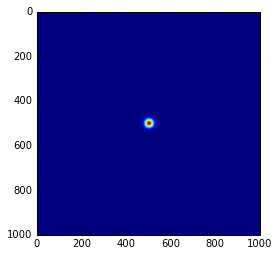

In [40]:
N = 1000

fortran_module = prepare_fortran_module(N=N)
fortran_diff2d, fortran_diff2d_a = fortran_module.fortran_diff2d, fortran_module.fortran_diff2d_a

u = calcF(N,1225,fortran_diff2d,dx2,dy2,c)
plt.imshow(u)

In [42]:
def calcF_a(N, Niter, func, dx2,dy2,c):
    u = np.zeros([N, N],order='F')
    v = np.zeros_like(u)
    u[u.shape[0]/2,u.shape[1]/2] = 1.0/np.sqrt(dx2*dy2)
    for i in range(Niter):
        func(u,dx2,dy2,c)
    return u

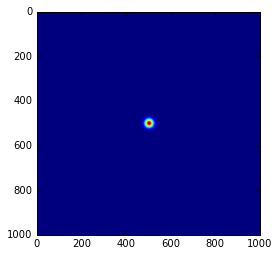

In [43]:
u = calcF_a(1000,1225,fortran_diff2d_a,dx2,dy2,c)
plt.imshow(u)

In [44]:
%%time
u = calc(1000,200,numpy_diff2d_a,dx2,dy2,c)

CPU times: user 2.05 s, sys: 144 ms, total: 2.2 s
Wall time: 2.03 s


In [45]:
%%time
u = calc(1000,200,cython_diff2d,dx2,dy2,c)

CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.04 s


In [46]:
fortran_diff2d = prepare_fortran_module(N=1000).fortran_diff2d

In [47]:
%%time
u = calcF(1000,200,fortran_diff2d,dx2,dy2,c)

CPU times: user 572 ms, sys: 0 ns, total: 572 ms
Wall time: 573 ms


In [48]:
%%time
u = calcF_a(1000,200,fortran_diff2d_a,dx2,dy2,c)


CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 609 ms
